In [ ]:
!pip install wget
import wget

wget.download("https://github.com/GrandmaCan/ML/raw/main/Classification/one_piece_mini.zip")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1ffabf13c9063fa39b1cc54c6f98088cb40ec097c0ef377c28031da2156780cb
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'one_piece_mini.zip'

In [ ]:
# 解壓縮
import zipfile

with zipfile.ZipFile("one_piece_mini.zip", "r") as zip_file: # "r": 讀取
  zip_file.extractall("one_piece_mini")

In [ ]:
# 我們需自行創建classes 這個屬性
with open("one_piece_mini/classnames.txt", "r") as f:
  lines = f.readlines()
  # print(lines)
  classes = [line.strip() for line in lines] # 我們不要顯示"/n"
  print(classes)

['Luffy', 'Nami', 'Zoro']


In [ ]:
from torch.utils.data import Dataset # 創建Dataset
from pathlib import Path # 引入Path 就可用根路徑
from PIL import Image # 為了顯示圖片
from torchvision import transforms # 為了對圖片做Resize

class ImageDataset(Dataset): # 創建一名為 ImageDataset 的類別, 並讓ImageDataset 繼承被引入的Dataset
  def __init__(self, root, train, transform=None):

    # train: 詢問現在是否讀取訓練集
    if train:
      image_root = Path(root) / "train"
    else:
      image_root = Path(root) / "test"

    # 讀取所有訓練集圖片
    self.paths = [i for i in image_root.rglob("*") if i.is_file()]

    # Resize 並轉換成Tensor 形式
    self.transform = transform

    with open(Path(root) / "classnames.txt", "r") as f: # 同with open("one_piece_mini / classnames.txt", "r") as f:
      lines = f.readlines()
      self.classes = [line.strip() for line in lines] # 同前面datasets.FashionMNIST 我們創建classes 這個屬性

  def __getitem__(self, index): # 中括號取值
    img = Image.open(self.paths[index]).convert("RGB") # 取值時讀取圖片
    class_name = self.paths[index].parent.name # 資料夾路徑
    class_idx = self.classes.index(class_name) # 從classnames 列表中找到其索引是多少

    # 是否需要轉換?, if 後回傳圖片與索引
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

  def __len__(self): # 回傳長度
    return len(self.paths) # 因為path 總長度與我們有幾張圖片的數值相同

In [ ]:
# 對圖片做Resize
# https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Resize.html#torchvision.transforms.v2.Resize
# 轉換成tensor 形式
# https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor

"""
resize = transforms.Resize((64, 64))
totensor = transforms.ToTensor()
totensor(resize(x)).shape
"""

# 串接在一起
train_transforms = transforms.Compose([
  transforms.Resize((64, 64)),

  # Data Augmentation 數據增強, 處理overfitting(過擬合) 的問題
  # https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide.html#torchvision.transforms.TrivialAugmentWide
  transforms.TrivialAugmentWide(),

  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [ ]:
# 實現上部分提及部分
train_dataset = ImageDataset("one_piece_mini", train=True, transform=image_transforms) # True: 現在是訓練集
x, y = train_dataset[50]
x.shape, y

(torch.Size([3, 300, 300]), 0)

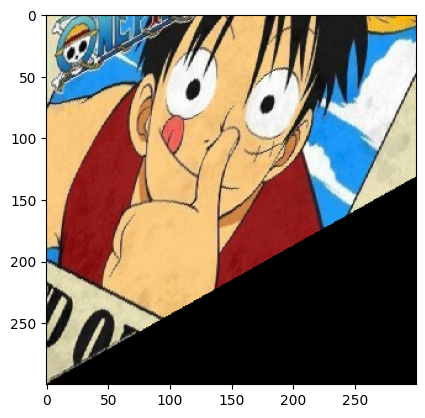

In [ ]:
import matplotlib.pyplot as plt
x, y = train_dataset[50]
plt.imshow(x.permute(1,2,0))

In [ ]:
# 創建訓練集與測試集Dataset
train_dataset = ImageDataset(root = "one_piece_mini", train=True, transform=train_transforms) # True: 現在是訓練集
test_dataset = ImageDataset(root = "one_piece_mini", train=False, transform=test_transforms) # False: 現在是測試集

In [ ]:
len(train_dataset), len(test_dataset)

(240, 60)

In [ ]:
x, y = test_dataset[0]
x.shape, y

(torch.Size([3, 64, 64]), 0)

In [ ]:
# 創建Dataloader 將資料分成數個Batch
from torch.utils.data import DataLoader

Batch_Size = 8

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=Batch_Size,
                              shuffle=True # 打亂
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=Batch_Size,
                              shuffle=False # 打亂
                              )

In [ ]:
len(train_dataloader), len(test_dataloader)

(30, 8)

In [ ]:
# 取出第一個Batch 看看
x_first_batch, y_first_batch = next(iter(train_dataloader))
x_first_batch.shape, y_first_batch.shape, x_first_batch[0].shape, y_first_batch[0]

(torch.Size([8, 3, 64, 64]),
 torch.Size([8]),
 torch.Size([3, 64, 64]),
 tensor(2))

In [ ]:
# 貼前面寫過的來用
# 定義模型
# 定義名為 ImageClassificationModel3 的類別，繼承了 PyTorch 中的 nn.Module 類別
from torch import nn
class ImageClassificationModel3(nn.Module): # 這表示 ImageClassificationModel3 是一個神經網路模型，可以使用 PyTorch 提供的模型相關功能
  def __init__(self, input_shape, output_shape): # 這是 ImageClassificationModel3 類別的初始化方法
    # 呼叫父類別（nn.Module）的初始化方法
    super().__init__() # super() 是一個內建函數，用來取得父類別的物件，這樣可以確保父類別的初始化方法被正確呼叫
    self.conv_block_1 = nn.Sequential(

      # 卷積神經網路
      # VCC: 卷積層 -> ReLU -> 卷積層 -> ReLU -> MaxPooling -> 卷積層 -> ReLU -> 卷積層 -> ReLU -> MaxPooling -> 全連接層 -> Softmax
      nn.Conv2d(in_channels=input_shape, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(start_dim=1, end_dim=-1),
      nn.Linear(in_features=16*16*16, out_features=output_shape),
      # nn.Softmax()
    )

  # 在PyTorch 中，所有的神經網路模型都需要實作一個名為forward的方法，該方法描述了輸入資料如何透過網路層進行計算，最終得到輸出
  def forward(self ,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x
    # return self.classifier(self.Convblock2(self.Convblock1(x)))

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = ImageClassificationModel3(3, len(train_dataset.classes)) # input_shape, output_shape: 因為是(3, 64, 64) 因此input_shape 是3
model.to(device)
model(x_first_batch.to(device))

tensor([[ 0.0074,  0.0098,  0.0036],
        [ 0.0042,  0.0064, -0.0013],
        [ 0.0026,  0.0061,  0.0018],
        [ 0.0087,  0.0056,  0.0002],
        [ 0.0060,  0.0073,  0.0006],
        [ 0.0041,  0.0064,  0.0056],
        [ 0.0044,  0.0085,  0.0024],
        [ 0.0026,  0.0098,  0.0054]], grad_fn=<AddmmBackward0>)

In [ ]:
# 設定cost function 跟optimizer (Adam)
# https://pytorch.org/docs/stable/optim.html
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001) # 用Adam 它會自行調整Learning Rate

In [ ]:
# 貼前面寫過的來用
def accuracy_fn(y_pred, y_true):

  correct_num = (y_pred==y_true).sum()
  acc = correct_num / len(y_true) * 100

  return acc

In [ ]:
# 新增訓練與測試步驟的程式碼
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device):
  train_cost = 0
  train_acc = 0
  for batch, (x, y) in enumerate(dataloader): # enumerate() 將迭代對象轉換為索引序列
    x = x.to(device)
    y = y.to(device)

    model.train()
    y_pred = model(x)
    cost = cost_fn(y_pred, y)
    train_cost += cost
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

  train_cost /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}")

def test_step(dataloader, model, cost_fn, accuracy_fn, device):
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      test_pred = model(x)
      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Test Cost: {test_cost:.4f}, Test Acc: {test_acc:.2f}\n")


In [ ]:
# 進度條
from tqdm.auto import tqdm
# 訓練模型
epochs = 10
for epoch in tqdm(range(epochs)): # 加入tqdm 進度條
  print(f"Epoch: {epoch}\n-------")
  train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model, cost_fn, accuracy_fn, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------

Train Cost: 1.1163, Train Acc: 30.00
Test Cost: 1.0948, Test Acc: 46.88

Epoch: 1
-------

Train Cost: 1.0806, Train Acc: 41.67
Test Cost: 1.0275, Test Acc: 43.75

Epoch: 2
-------

Train Cost: 1.0013, Train Acc: 51.25
Test Cost: 0.9306, Test Acc: 60.94

Epoch: 3
-------

Train Cost: 0.8804, Train Acc: 64.58
Test Cost: 0.8443, Test Acc: 70.31

Epoch: 4
-------

Train Cost: 0.8436, Train Acc: 65.42
Test Cost: 0.8663, Test Acc: 70.31

Epoch: 5
-------

Train Cost: 0.8867, Train Acc: 63.75
Test Cost: 0.8443, Test Acc: 70.31

Epoch: 6
-------

Train Cost: 0.8328, Train Acc: 67.08
Test Cost: 0.7047, Test Acc: 73.44

Epoch: 7
-------

Train Cost: 0.7817, Train Acc: 65.42
Test Cost: 0.7539, Test Acc: 71.88

Epoch: 8
-------

Train Cost: 0.7827, Train Acc: 67.08
Test Cost: 0.7245, Test Acc: 68.75

Epoch: 9
-------

Train Cost: 0.7185, Train Acc: 71.67
Test Cost: 0.6755, Test Acc: 76.56



In [ ]:
# 引入圖片"luffy.jpeg" 並做分類預測
img = Image.open("luffy.jpeg").convert("RGB")
img = test_transforms(img)
img = img.reshape(-1, 3, 64, 64) # 變四維
model.eval()
with torch.inference_mode():
  y_pred = model(img.to(device))

y_pred = torch.softmax(y_pred, dim=1)
class_idx = y_pred.argmax(dim=1)
train_dataset.classes[class_idx]

'Luffy'

Python 中的列表生成式(list comprehension)是一種簡潔的語法，用於創建新的列表,通常基於現有的可迭代對象(如列表、元組、集合或字串)進行轉換或過濾。列表生成式的基本語法如下：

new_list = [expression for item in iterable if condition]


In [ ]:
image_root = Path("one_piece_mini") / "train"

'''
for i in image_root.rglob("*"): # 可以讀取底下所有資料夾
  if i.is_file(): # 我們僅要檔案而非資料夾
    print(i)
'''

path = [i for i in image_root.rglob("*") if i.is_file()] # 簡化上方寫法
print(len(path), path)



240 [PosixPath('one_piece_mini/train/Luffy/64.jpg'), PosixPath('one_piece_mini/train/Luffy/12.jpg'), PosixPath('one_piece_mini/train/Luffy/25.jpg'), PosixPath('one_piece_mini/train/Luffy/70.jpg'), PosixPath('one_piece_mini/train/Luffy/11.jpg'), PosixPath('one_piece_mini/train/Luffy/72.jpg'), PosixPath('one_piece_mini/train/Luffy/48.jpg'), PosixPath('one_piece_mini/train/Luffy/5.jpg'), PosixPath('one_piece_mini/train/Luffy/3.jpg'), PosixPath('one_piece_mini/train/Luffy/90.jpg'), PosixPath('one_piece_mini/train/Luffy/15.jpg'), PosixPath('one_piece_mini/train/Luffy/6.jpg'), PosixPath('one_piece_mini/train/Luffy/56.jpg'), PosixPath('one_piece_mini/train/Luffy/1.jpg'), PosixPath('one_piece_mini/train/Luffy/79.jpg'), PosixPath('one_piece_mini/train/Luffy/59.jpg'), PosixPath('one_piece_mini/train/Luffy/88.jpg'), PosixPath('one_piece_mini/train/Luffy/18.jpg'), PosixPath('one_piece_mini/train/Luffy/54.jpg'), PosixPath('one_piece_mini/train/Luffy/19.jpg'), PosixPath('one_piece_mini/train/Luffy/3

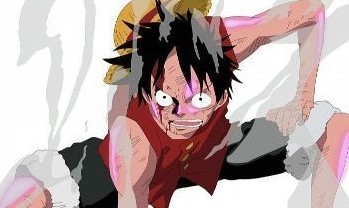

In [ ]:
# 顯示圖片
from PIL import Image
image_root = Path("one_piece_mini") / "train"
path = [i for i in image_root.rglob("*") if i.is_file()] # 簡化上方寫法
Image.open(path[1]).convert("RGB")

In [ ]:
# 更大的數據集
import requests

url = "https://firebasestorage.googleapis.com/v0/b/grandmacan-2dae4.appspot.com/o/ML_data%2Fone_piece_full.zip?alt=media&token=937656fd-f5c1-44f5-b174-1e2d590b8ef3"

with open("one_piece_full.zip", "wb") as f: # 因為是二進制因此用"wb"
  req = requests.get(url)
  f.write(req.content)

In [ ]:
# 貼前面寫過的來用
import zipfile

with zipfile.ZipFile("one_piece_full.zip", "r") as zip_file:
  zip_file.extractall("one_piece_full")

In [ ]:
# 貼前面寫過的來用
# 創建訓練集與測試集Dataset
train_dataset = ImageDataset(root="one_piece_full", train=True, transform=train_transforms)
test_dataset = ImageDataset(root="one_piece_full", train=False, transform=test_transforms)

In [ ]:
# 貼前面寫過的來用
len(train_dataset), len(test_dataset)

(3015, 750)

In [ ]:
# 貼前面寫過的來用
# 創建Dataloader 將資料分成數個Batch
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset,
                batch_size=BATCH_SIZE,
                shuffle=True
)

test_dataloader = DataLoader(dataset=test_dataset,
                batch_size=BATCH_SIZE,
                shuffle=False
)

In [ ]:
# 貼前面寫過的來用
len(train_dataloader), len(test_dataloader)

(189, 47)

In [ ]:
# 貼前面寫過的來用
model_2 = ImageClassificationModel3(3, len(train_dataset.classes))
model_2.to(device)

ImageClassificationModel3(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=18, bias=True)
  )
)

In [ ]:
# 貼前面寫過的來用
# 設定cost function 跟optimizer (Adam)
# https://pytorch.org/docs/stable/optim.html
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [ ]:
# 貼前面寫過的來用
from tqdm.auto import tqdm

epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")

  train_step(train_dataloader, model_2, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model_2, cost_fn, accuracy_fn, device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Train Cost: 2.8472, Train Acc: 9.39
Test Cost: 2.7485, Test Acc: 12.77

Epoch: 1
-------

Train Cost: 2.7745, Train Acc: 12.92
Test Cost: 2.6600, Test Acc: 18.47

Epoch: 2
-------

Train Cost: 2.6828, Train Acc: 16.01
Test Cost: 2.5036, Test Acc: 20.82

Epoch: 3
-------

Train Cost: 2.5883, Train Acc: 20.48
Test Cost: 2.3966, Test Acc: 24.72

Epoch: 4
-------

Train Cost: 2.4575, Train Acc: 25.09
Test Cost: 2.2603, Test Acc: 29.33

Epoch: 5
-------

Train Cost: 2.3300, Train Acc: 29.63
Test Cost: 2.1529, Test Acc: 35.07

Epoch: 6
-------

Train Cost: 2.2074, Train Acc: 33.01
Test Cost: 2.0982, Test Acc: 34.56

Epoch: 7
-------

Train Cost: 2.1271, Train Acc: 37.50
Test Cost: 2.1224, Test Acc: 38.11

Epoch: 8
-------

Train Cost: 2.0478, Train Acc: 40.09
Test Cost: 1.9886, Test Acc: 39.10

Epoch: 9
-------

Train Cost: 1.9640, Train Acc: 41.99
Test Cost: 1.9160, Test Acc: 40.50

